In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.autograd import Variable

import torch.utils.data

import pandas as pd
import numpy as np

import pdb
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

from torch.nn.utils import clip_grad_norm


# import torch.backends.cudnn as cudnn
# cudnn.benchmark = True
import os

use_cuda = True


GPU_ids = [1]
GPU_id = GPU_ids[0]

os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(ID) for ID in GPU_ids])
GPU_ids = list(range(0, len(GPU_ids)))

torch.cuda.device_count()

1

In [2]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

import torch
import torch.utils.data 
from torch.autograd import Variable

import pandas as pd
import numpy as np

from seq2loc.utils import *

import math

class SequenceDatasetDummy(torch.utils.data.Dataset):
    def __init__(self, sequence_path = './data/uniprot.csv', max_seq_len = 25, mlb = None):
        self.max_seq_len = max_seq_len
        
        self.dummy_seq = ['', 'ASDFASDFASDF', 'FAAAAAAAAD']
        
        column_name = 'GO id'
        
        df = pd.read_csv(sequence_path)

        df = df.dropna(subset=[column_name])
        df = df.reset_index(drop=True)

        if mlb is None:
            mlb = MultiLabelBinarizer()
            mlb.fit([self.dummy_seq])
        

        some_hot_targets = mlb.transform([self.dummy_seq])
    
        df_sequences = df['Sequence']

        #Trim out the bonkers long sequences
        seq_lengths = [len(seq) for seq in df_sequences]
        max_len = np.percentile(seq_lengths, 99.5)
        
        keep_inds = seq_lengths <= max_len
        
        df_sequences = df_sequences[keep_inds].reset_index(drop=True)

        self.somehot = some_hot_targets
        self.pd_sequences = df_sequences
        
        self.mlb = mlb
        
    def __getitem__(self, index):
    
        class_index = np.random.randint(len(self.dummy_seq))
        
        seq = self.pd_sequences[index]
        
        if len(seq) > self.max_seq_len:
            start = np.random.randint(len(seq)-self.max_seq_len)
            seq = seq[start:(start+self.max_seq_len)]
            
        sequence_to_insert = self.dummy_seq[class_index]
        splitloc = np.random.randint(len(seq))
        
        seq = seq[0:splitloc] + sequence_to_insert + seq[splitloc:]
            
        tensor_indices = lineToIndices(seq)

            
        label = torch.zeros(len(self.dummy_seq))
        label[class_index] = 1
            
        return tensor_indices, label
        
    def __len__(self):
        return len(self.pd_sequences)
    

class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequence_path = './data/uniprot.csv', max_seq_len = 25, mlb = None):
        self.max_seq_len = max_seq_len
        
        column_name = 'GO id'
        
        df = pd.read_csv(sequence_path)

        df = df.dropna(subset=[column_name])
        df = df.reset_index(drop=True)

        if mlb is None:
            mlb = MultiLabelBinarizer()
            mlb.fit(df[column_name].str.split(';').tolist())
        
        some_hot_targets = mlb.transform(df[column_name].str.split(';').tolist())
        df['GOsomehot'] = pd.Series(tuple(some_hot_targets.astype(np.float32)))

        
        df_somehot = df['GOsomehot']
        
        df_sequences = df['Sequence']

        #Trim out the bonkers long sequences
        seq_lengths = [len(seq) for seq in df_sequences]
        max_len = np.percentile(seq_lengths, 99.5)
        
        keep_inds = seq_lengths <= max_len
        
        df_sequences = df_sequences[keep_inds].reset_index(drop=True)

        self.somehot = df_somehot[keep_inds].reset_index(drop=True)
        self.pd_sequences = df_sequences
        
        self.mlb = mlb
        
    def __getitem__(self, index):
    
        seq = self.pd_sequences[index]
        
        if len(seq) <= self.max_seq_len:
            tensor_indices = lineToIndices(seq)
        else:
            start = np.random.randint(len(seq)-self.max_seq_len)
            
            tensor_indices = lineToIndices(seq[start:(start+self.max_seq_len)])
            
        somehot = self.somehot[index]
            
        return tensor_indices, torch.Tensor(somehot)
        
    def __len__(self):
        return len(self.pd_sequences)
    
class PaddedSequenceDataset(torch.utils.data.Dataset):
        def __init__(self, sequenceDataset, GPU_id = None):
            self.sequenceDataset = sequenceDataset
            self.GPU_id = GPU_id
            
        def __getitem__(self, indices):
            
            sequence_tensor_indices = list()
            somehots = list()
            
            #get all the sequences as a list of character indices
            for index in indices:
                tensor_indices, somehot = self.sequenceDataset[index]
                sequence_tensor_indices += [Variable(tensor_indices)]
                somehots += [Variable(somehot)]
                
            #get the longest sequence
            ind = np.argmax([len(s) for s in sequence_tensor_indices])
            
            tensor_len = len(sequence_tensor_indices[ind])
            nchars = n_letters()
            
            #pad all shorter sequences with the stop character
            for i in range(len(sequence_tensor_indices)):
                
                my_inds = sequence_tensor_indices[i]
                my_len = my_inds.shape[0]

                sequence_tensor_indices[i] = torch.unsqueeze(torch.cat([my_inds, Variable(torch.ones(tensor_len - my_len).long()*(nchars-1))]), 1)
            
            sequence_tensor_indices = torch.cat(sequence_tensor_indices, 1)
            
            somehots = torch.stack(somehots)
            
            sequence_tensors = Variable(indicesToTensor(sequence_tensor_indices))
            
            if self.GPU_id is not None:
                sequence_tensors = sequence_tensors.cuda(self.GPU_id)
                somehots = somehots.cuda(self.GPU_id)
                
            return sequence_tensors, somehots            
            
        def __len__(self):
            return len(self.sequenceDataset)

In [3]:

class Attention(nn.Module):
    def __init__(self, attn_in_size, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size

        self.attn = nn.Sequential(
                                    nn.Linear(attn_in_size, hidden_size)
                                )
        
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs_tmp = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(h, encoder_outputs_tmp)
        
        attn_weights = F.softmax(attn_energies, dim=1).unsqueeze(1)
        
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # (B,1,N)
        context = context.transpose(0, 1)  # (1,B,N)
        
        return context, attn_weights

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
        energy = self.attn(torch.cat([hidden, encoder_outputs], 2))
        
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]

class SequenceClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_gru_layers=1, bidirectional = True, dropout_p = 0.2):
        super(SequenceClassifier, self).__init__()
        
        self.h_layers = num_gru_layers
        self.hidden_size = hidden_size
        self.num_gru_layers = num_gru_layers
        self.h_layers = num_gru_layers
        
        n_attention_heads = 6
        
        lin_in = self.h_layers * self.hidden_size
        
        gru_out_size = hidden_size
        if bidirectional:
            self.h_layers *= 2
            lin_in *=  2
            gru_out_size *= 2
    
            
        self.gru = nn.GRU(input_size, hidden_size, num_layers = num_gru_layers, bidirectional = bidirectional, dropout = dropout_p)
        
        
        self.atten_list = nn.ModuleList(Attention(lin_in+ gru_out_size, hidden_size) for i in range(n_attention_heads))
        
        self.out = nn.Sequential(
                                 nn.Linear(lin_in + gru_out_size*n_attention_heads, output_size)
                                )
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)     
        
        hidden = torch.cat([h for h in hidden],1)
        
        context_list, attn_list = list(), list()
        for i, atten_head in enumerate(self.atten_list):
            
            context, attn_weights = atten_head(hidden, output)
            
            context_list.append(torch.squeeze(context.transpose(0, 1)))
            attn_list.append(attn_weights)

        output = torch.cat([hidden] + context_list, 1)

        output = self.out(output)
        
        return output

    def initHidden(self, batch_size = 1):
        result = Variable(torch.zeros(self.h_layers, batch_size, self.hidden_size))
        
        return result
#         if use_cuda:
#             return result.cuda()
#         else:
#             return result
  


In [ ]:
import os
from decimal import Decimal

import seq2loc.utils as utils

from tensorboardX import SummaryWriter

# from seq2loc.data.datasets import PaddedSequenceDataset, SequenceDataset


GPU_id = 0
LR = 0.001
N_EPOCHS = 500
hidden_size = 256
batch_size = 32
num_gru_layers = 2

N_LETTERS = utils.n_letters()

grad_clip = 10.0

bidirectional=True

#really big number to trim sequences to
max_seq_len = 4000

ds = PaddedSequenceDataset(SequenceDataset('./data/hpa_data_resized_train.csv', max_seq_len = max_seq_len), GPU_id = GPU_id)
ds_test = PaddedSequenceDataset(SequenceDataset('./data/hpa_data_resized_test.csv', max_seq_len = max_seq_len, mlb = ds.sequenceDataset.mlb), GPU_id = GPU_id)
ds_validate = PaddedSequenceDataset(SequenceDataset('./data/hpa_data_resized_validate.csv', max_seq_len = max_seq_len, mlb = ds.sequenceDataset.mlb), GPU_id = GPU_id)

criterion = torch.nn.BCEWithLogitsLoss()

enc = SequenceClassifier(N_LETTERS, 33, hidden_size, num_gru_layers, bidirectional=bidirectional).cuda(GPU_id)

opt = optim.Adam(enc.parameters(), lr = LR)

writer = SummaryWriter()

save_dir = './classifier/{}'

iteration = 0

for epoch in range(N_EPOCHS):

    epoch_inds = utils.get_epoch_inds(len(ds), batch_size)
    pbar = tqdm(epoch_inds)

    epoch_losses = list()
    
    for batch in pbar:
        opt.zero_grad()

        x, y = ds[batch]        
        
        hidden = enc.initHidden(batch_size).cuda(GPU_id)
        y_hat  = enc(x, hidden)
        
        loss = criterion(y_hat, y)
     
        loss.backward()
        clip_grad_norm(enc.parameters(), grad_clip)

        opt.step()

        losses_np = np.squeeze(loss.detach().cpu().numpy())
        
        epoch_losses += [losses_np]
    #     t.set_description('GEN %i' % i)
        pbar.set_description('%.4E' % Decimal(str(losses_np)))
        
        writer.add_scalars(save_dir.format('train'), {'epoch': epoch,
                                                        'loss': losses_np}, iteration)
        
        iteration += 1
        

    enc.train(False)
    
    x, y = ds_test[utils.get_epoch_inds(len(ds_test), batch_size)[0]]
    hidden = enc.initHidden(batch_size).cuda(GPU_id)
    with torch.no_grad():
        y_hat  = enc(x, hidden)
    loss = criterion(y_hat, y)
    losses_test = np.squeeze(loss.detach().cpu().numpy())
    
    writer.add_scalars(save_dir.format('test'), {'epoch': epoch,
                                                 'loss': losses_np}, iteration)
    
    enc.train(True)
    
    
    pbar.set_description('%.4E' % Decimal(str(np.mean(epoch_losses))))
    


In [6]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
mlb = ds.sequenceDataset.mlb
# enc.train(False)

# epoch_inds = utils.get_epoch_inds(len(ds_test), batch_size)

# y_list = list()
# y_hat_list = list()

# for batch in tqdm(epoch_inds):
    
#     x, y = ds_test[batch]        
#     hidden = enc.initHidden(batch_size).cuda(GPU_id)
#     with torch.no_grad():
#         y_hat  = nn.Sigmoid()(enc(x, hidden))
    
    
#     y_list += [y]
#     y_hat_list += [y_hat]
    

# y = torch.cat(y_list).cpu().numpy()
# y_hat = torch.cat(y_hat_list).cpu().numpy()

# thresh = 0.5


true_labs = y
pred_acts = y_hat
pred_labs = np.zeros_like(pred_acts)
pred_labs[pred_acts > thresh] = 1

df_stats = pd.DataFrame()
for i,col in enumerate(mlb.classes_):

    # get true labels and predicted activations
    true_labs_col = true_labs[:,i]
    pred_acts_col = pred_acts[:,i]
    pred_labs_col = pred_labs[:,i]

    # compute one against all prec + recall stats
    p,r,f,_ = precision_recall_fscore_support(true_labs_col,pred_labs_col, average='binary')
    df_stats.loc[i,'precision_{}'.format(thresh)] = p
    df_stats.loc[i,'recall_{}'.format(thresh)] = r
    df_stats.loc[i,'f1score_{}'.format(thresh)] = f
    df_stats.loc[i,'auprc'] = average_precision_score(true_labs_col, pred_acts_col)
    df_stats.loc[i,'support'] = int(true_labs_col.sum())
    df_stats.loc[i,'label'] = col
    
    
    
enc.train(True)  

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


SequenceClassifier(
  (gru): GRU(23, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (atten_list): ModuleList(
    (0): Attention(
      (attn): Sequential(
        (0): Linear(in_features=1536, out_features=256, bias=True)
      )
    )
    (1): Attention(
      (attn): Sequential(
        (0): Linear(in_features=1536, out_features=256, bias=True)
      )
    )
    (2): Attention(
      (attn): Sequential(
        (0): Linear(in_features=1536, out_features=256, bias=True)
      )
    )
    (3): Attention(
      (attn): Sequential(
        (0): Linear(in_features=1536, out_features=256, bias=True)
      )
    )
    (4): Attention(
      (attn): Sequential(
        (0): Linear(in_features=1536, out_features=256, bias=True)
      )
    )
    (5): Attention(
      (attn): Sequential(
        (0): Linear(in_features=1536, out_features=256, bias=True)
      )
    )
  )
  (out): Sequential(
    (0): Linear(in_features=4096, out_features=33, bias=True)
  )
)

In [7]:
df_stats

,precision_0.5,recall_0.5,f1score_0.5,auprc,support,label
0,0.000000,0.000000,0.000000,0.029031,88.0,Actin filaments (GO:0015629)
1,0.000000,0.000000,0.000000,0.015530,18.0,Aggresome (GO:0016235)
2,0.393939,0.134021,0.200000,0.117678,194.0,Cell Junctions (GO:0030054)
3,0.000000,0.000000,0.000000,0.017745,169.0,Centrosome (GO:0005813)
4,0.000000,0.000000,0.000000,NaN,0.0,Cleavage furrow (GO:0032154)
5,0.000000,0.000000,0.000000,0.006784,71.0,Cytokinetic bridge (GO:0045171)
6,0.000000,0.000000,0.000000,0.002286,28.0,Cytoplasmic bodies (GO:0036464)
7,0.443589,0.499811,0.470025,0.445268,2651.0,Cytosol (GO:0005829)
8,0.369231,0.110599,0.170213,0.226962,217.0,Endoplasmic reticulum (GO:0005783)
9,0.000000,0.000000,0.000000,NaN,0.0,Endosomes (GO:0005768)


In [44]:
y = torch.cat(y_list).cpu().numpy()
y_hat = torch.cat(y_hat_list).cpu().numpy()

for i in range(y.shape[1]):
    label_inds = np.where(y[:,i]>0)[0]
    
    print(np.mean(y[label_inds,i] == y_hat[label_inds,i]))


0.0
0.0
0.13402061855670103
0.0
nan
0.0
0.0
0.4037735849056604
0.1935483870967742
nan
0.0
0.05873715124816446
0.041379310344827586
0.0
0.0
0.0
0.12121212121212122
0.031088082901554404
0.0
0.0
0.32679738562091504
0.0
0.1393939393939394
0.03314917127071823
0.0
0.08909730363423213
0.0
0.4092987804878049
0.11727912431587177
nan
0.17647058823529413
0.0
0.14380714879467996


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
y_hat[label_inds,i]

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

torch.Size([2161, 32, 23])



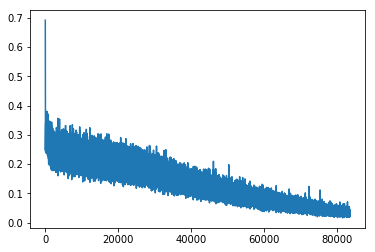

In [8]:
import matplotlib.pyplot as plt

print(x.shape)
print()

plt.plot(losses)
plt.show()

In [15]:
np.equal(y.cpu().data.numpy(), nn.Sigmoid()(y_hat).cpu().data.numpy()>0.5)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True],


In [25]:
np.log(np.exp(3.219125824868201)/28)

-0.11307868530700314

In [71]:
enc.train(False)
dec.train(False)

x_tmp, _ = ds[[np.random.randint(len(ds))]]

# x = torch.unsqueeze(x[:,0,:],1)
batch_size_tmp = x_tmp.shape[1]

hidden = enc.initHidden(batch_size_tmp).cuda(GPU_id)
out, hidden = enc(x_tmp, hidden)

#input the stop character to the stream    
out = Variable(stopChar(batch_size_tmp)).cuda(GPU_id)


#     pdb.set_trace()
out_chars = list()

for i in range(x_tmp.shape[0]):

    out, hidden = dec(out, hidden) 
    
    out_chars += [tensorToChar(out)[0,0]]
    
enc.train(True)
dec.train(True)

print(''.join(np.hstack(tensorToChar(x_tmp))))
print(''.join(out_chars))

MSLMVVSMACVGFFLLEGPW
MMHCTPCLLLMMMMMMMMMM


In [51]:
3E-4*np.log(15)

0.0008124150603306629

In [41]:
6.77e-05/np.log(15)

2.499953655676149e-05